Image classification with CNNs
================

This notebook is based on the exercise notebooks of the course "Introduction to Deep Learning". We used a three-layer CNN to perform the classification task on the dataset CIFAR10 (32x32 images with 10 classes).

The bullet points are my suggestions what we need to do. 
****
The text below the grey lines is still from the original notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable


from exercise_code.classifiers.classification_cnn import ClassificationCNN
# specific for CIFAR10 dataset:
from exercise_code.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Dataset
=========

* Load the preprocessed datasets in patches of the same size (input size of network so far 32x32 pixel)
* Split data in train - val - test data
* How to treat unequal distribution of benign and malingant cases?

****
For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the <code>Dataset</code> classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the <code>Dataset</code> classes. See <code>torchvision.Transform</code> for examples.</p>
</div> 

In [3]:
from exercise_code.data_utils import load_mammography_data

train_data = load_mammography_data('data/train.txt')
val_data = load_mammography_data('data/val.txt')
test_data = load_mammography_data('data/test.txt')


# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 475
Val size: 190
Test size: 190


Visualize Data
------------------
* Visualize some of the patches with according classlabels 

****
To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

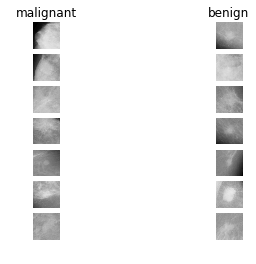

In [7]:
### TODO
classes = ['malignant', 'benign']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0))# + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
#Example from Cifar10 website
#draw_sample(X_train, y_train, 0, 3, 5)

## Train the Network

* Plot validation and training curve
* Hyperparameter optimization
* Visualize filters to see if network learns meaningful features

We can copy each of these methods from the notebooks 1_classification_cnn and 2_segmentation_nn


****


In [16]:
from exercise_code.classifiers.classification_mammograms import ClassificationCNN
from exercise_code.solver import Solver

############################################################################
# TODO: Initialize a model and train it using your Solver class. Start     #
# with the previously given set of hyperparameters.                        #
############################################################################
best_model = None

num_epochs = 10
batch_size = [16,32,64]

regs = [1e-5]
#weight_scales = [1e-3]
learning_rates = [5e-4,1e-3,5e-3]

for batch in batch_size:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=1)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch, shuffle=False, num_workers=1)
    for lr in learning_rates:
       # for reg in regs:
        model = ClassificationCNN()
        solver = Solver(optim_args={"lr": lr})#, 
                                        #"betas": (0.9, 0.999),
                                        #"eps": 1e-8,
                                        #"weight_decay": 0.0})

        solver.train(model, train_loader, val_loader, log_nth=1000, num_epochs=num_epochs)
        print(lr,batch)
            


START TRAIN.
[Epoch 1/10] TRAIN acc/loss: 0.455/1.227
[Epoch 1/10] VAL   acc/loss: 0.570/0.750
[Epoch 2/10] TRAIN acc/loss: 0.455/0.991
[Epoch 2/10] VAL   acc/loss: 0.581/0.701
[Epoch 3/10] TRAIN acc/loss: 0.545/0.903
[Epoch 3/10] VAL   acc/loss: 0.570/0.695
[Epoch 4/10] TRAIN acc/loss: 0.636/0.852
[Epoch 4/10] VAL   acc/loss: 0.430/0.741
[Epoch 5/10] TRAIN acc/loss: 0.545/0.824
[Epoch 5/10] VAL   acc/loss: 0.570/0.769
[Epoch 6/10] TRAIN acc/loss: 0.727/0.806
[Epoch 6/10] VAL   acc/loss: 0.570/0.720
[Epoch 7/10] TRAIN acc/loss: 0.455/0.791
[Epoch 7/10] VAL   acc/loss: 0.596/0.678
[Epoch 8/10] TRAIN acc/loss: 0.364/0.781
[Epoch 8/10] VAL   acc/loss: 0.440/0.696
[Epoch 9/10] TRAIN acc/loss: 0.636/0.772
[Epoch 9/10] VAL   acc/loss: 0.570/0.773
[Epoch 10/10] TRAIN acc/loss: 0.727/0.767
[Epoch 10/10] VAL   acc/loss: 0.570/0.687
FINISH.
0.0005 16
START TRAIN.
[Epoch 1/10] TRAIN acc/loss: 0.727/1.933
[Epoch 1/10] VAL   acc/loss: 0.429/0.832
[Epoch 2/10] TRAIN acc/loss: 0.455/1.346
[Epoch 2/10

In [7]:
#This is working!
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=1)
#for i, [inputs,targets] in enumerate(train_loader, 1):
 #   print(i)
  #  print(inputs)
   # print(targets)
#train_loader.size

In [8]:
#Here is the problem... it's from the solver.py 
#for i, [inputs,targets] in enumerate(train_loader, 1):
 #   print(i)
  #  print(inputs)
   # print(targets)

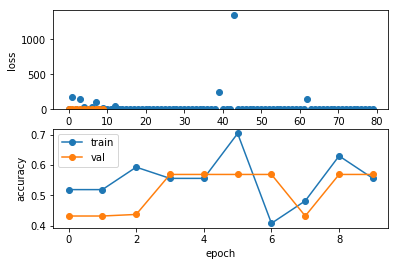

In [21]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
#plt.axis([xmin, xmax, ymin, ymax])
plt.axis(ymin=0)

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Test your Model
Run your best model on the test set.

## Save the Model